# Dutch-Floral-Painting: Autoencoder
by Sonia Hashim

In [0]:
%tensorflow_version 2.x
import tensorflow as tf 
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import os
tf.__version__

TensorFlow 2.x selected.


'2.0.0'

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
!tar -zxvf "drive/My Drive/00-Research/data/dutch-floral-painting/ims.tar.gz"

In [0]:
!ls

drive  processed  sample_data


In [0]:
!rm 'processed/.DS_Store'
!rm 'processed/._.DS_Store'

In [0]:
!ls 'processed/'

00.daffodils   04.crocus     08.fritillary  12.dandelion   16.pansy
01.snowdrop    05.iris	     09.sunflower   13.cowslip
02.lilyvalley  06.tigerlily  10.daisy	    14.buttercup
03.bluebell    07.tulip      11.coltsfoot   15.windflower


In [0]:
dir_processed = 'processed'
im = plt.imread(dir_processed+'/00.daffodils'+'/image_0001.png')
im.shape

(256, 256, 3)

#### Data Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ndim = 256
batch_size = 8

img_gen = ImageDataGenerator(rescale=1./255,
                            #  width_shift_range = 10,
                            #  height_shift_range = 10,
                             horizontal_flip = True,
                             rotation_range = 15,
                            #  zoom_range = 0.2,
                             validation_split = 0.1)

data_gen = img_gen.flow_from_directory(batch_size = batch_size,
                                       directory = dir_processed,
                                       shuffle = True, 
                                       target_size = (ndim, ndim),
                                       color_mode = 'rgb',
                                       class_mode = 'input',
                                       subset='training')
valid_gen = img_gen.flow_from_directory(batch_size = batch_size,
                                       directory = dir_processed,
                                       shuffle = True, 
                                       target_size = (ndim, ndim),
                                       color_mode = 'rgb',
                                       class_mode = 'input',
                                       subset='validation')

Found 767 images belonging to 17 classes.
Found 79 images belonging to 17 classes.


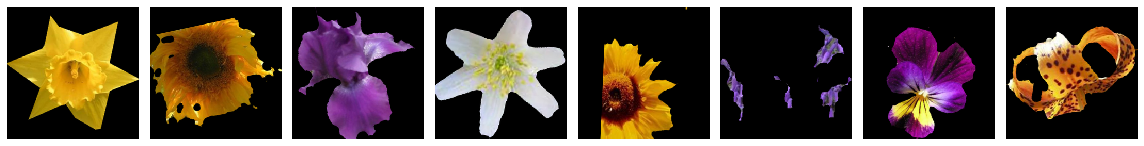

In [0]:
# Visualize images from data generator 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(16,8))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_imgs, _ = next(data_gen)
plotImages(sample_imgs)

### Model 00

In [0]:
# Decoder & Autencoder 00 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=sample_imgs[0].shape, name='input')

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded0 = MaxPooling2D((2, 2), padding='same')(x)

latent_input = Input(shape=(8, 8, 1), name='latent_input')
z = UpSampling2D((2, 2))(latent_input)
z = Conv2D(2, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(4, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(8, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
decoded0 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(z)

decoder0 = Model(latent_input, decoded0, name='decoder00')
decoder0.summary()
autoencoder0 = Model(input_img, decoder0(encoded0), name='autoencoder00')
autoencoder0.compile(optimizer='adagrad', loss='mse')
autoencoder0.summary()

Model: "decoder00"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, 8, 8, 1)]         0         
_________________________________________________________________
up_sampling2d_224 (UpSamplin (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_551 (Conv2D)          (None, 16, 16, 2)         20        
_________________________________________________________________
up_sampling2d_225 (UpSamplin (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_552 (Conv2D)          (None, 32, 32, 4)         76        
_________________________________________________________________
up_sampling2d_226 (UpSamplin (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_553 (Conv2D)          (None, 64, 64, 8)         29

### Model 01 

In [0]:
# Decoder & Autencoder 01
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

k = 3
input_img = Input(shape=sample_imgs[0].shape, name='input')

x = Conv2D(8, kernel_size=k, strides=2, activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, kernel_size=k, strides=2, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, kernel_size=k, strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, kernel_size=k, strides=2, activation='relu', padding='same')(x)
encoded1 = Flatten()(x)

latent_input = Input(shape=(None, 2048), name='latent_input')
z = Reshape((4,4,128))(latent_input)
z = Conv2DTranspose(64, kernel_size=k, strides=2, activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2DTranspose(16, kernel_size=k, strides=2, activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2DTranspose(8, kernel_size=k, strides=2, activation='relu', padding='same')(z)
decoded1 = Conv2DTranspose(3, kernel_size=3, strides=2, activation='sigmoid', padding='same')(z)

decoder1 = Model(latent_input, decoded1, name='decoder01')
decoder1.summary()
autoencoder1 = Model(input_img, decoder1(encoded1), name='autoencoder01')
autoencoder1.compile(optimizer='adagrad', loss='mse')
autoencoder1.summary()

Model: "decoder01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, None, 2048)]      0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_126 (Conv2D (None, 8, 8, 64)          73792     
_________________________________________________________________
up_sampling2d_229 (UpSamplin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_127 (Conv2D (None, 32, 32, 16)        9232      
_________________________________________________________________
up_sampling2d_230 (UpSamplin (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_transpose_128 (Conv2D (None, 128, 128, 8)       11

### Model 02

In [0]:
# Decoder & Autencoder 02
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

input_img = Input(shape=sample_imgs[0].shape, name='input')

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

latent_input = Input(shape=(None, 64), name='latent_input')
z = Reshape((8,8,1))(latent_input)
z = UpSampling2D((2, 2))(z)
z = Conv2D(2, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(4, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(8, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(16, (3, 3), activation='relu', padding='same')(z)
z = UpSampling2D((2, 2))(z)
decoded2 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(z)

decoder2 = Model(latent_input, decoded2, name='decoder02')
decoder2.summary()
autoencoder2 = Model(input_img, decoder2(encoded2), name='autoencoder02')
autoencoder2.compile(optimizer='adagrad', loss='mse')
autoencoder2.summary()

In [0]:
# Calculate compression
256*256*3/(2048)

# Extract one image to train on
one_batch = next(data_gen)
one_x = np.array([one_batch[0][0]])
one_y = one_batch[1]

nepochs = 500
ntrain = batch_size
nsteps_per_epoch = 1
earlystopping_cb = EarlyStopping(monitor='loss', patience=3)
test_one = autoencoder.fit(one_x, one_x,
                           epochs = nepochs,
                           batch_size = 1,
                           callbacks=[earlystopping_cb],
                           initial_epoch=0)

y = autoencoder.predict(one_x)
plt.imshow(y.reshape(256,256,3))
# plt.imshow(one_x.reshape(256,256,3))

96.0

### Training

In [0]:
# files.upload()
decoder = tf.keras.models.load_model("decoder01.h5")
decoder.summary()
# autoencoder = tf.keras.models.load_model("autoencoder01.h5")
# autoencoder.summary()

Model: "decoder01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, None, 2048)]      0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_126 (Conv2D (None, 8, 8, 64)          73792     
_________________________________________________________________
up_sampling2d_229 (UpSamplin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_127 (Conv2D (None, 32, 32, 16)        9232      
_________________________________________________________________
up_sampling2d_230 (UpSamplin (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_transpose_128 (Conv2D (None, 128, 128, 8)       11

In [0]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping

nepochs = 410
ntrain = 846 

nsteps_per_epoch = ceil(ntrain/batch_size)
earlystopping_cb = EarlyStopping(monitor='val_loss', patience=7)

history = autoencoder.fit_generator(generator=data_gen,
                                    validation_data=valid_gen,
                                    steps_per_epoch = nsteps_per_epoch,
                                    epochs = nepochs,
                                    initial_epoch=399)

Epoch 400/410
106/106 [==============================] - 37s 346ms/step - loss: 0.0254 - val_loss: 0.0251
Epoch 401/410
106/106 [==============================] - 36s 339ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 402/410
106/106 [==============================] - 36s 340ms/step - loss: 0.0252 - val_loss: 0.0247
Epoch 403/410
106/106 [==============================] - 36s 338ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 404/410
106/106 [==============================] - 36s 338ms/step - loss: 0.0251 - val_loss: 0.0247
Epoch 405/410
106/106 [==============================] - 36s 338ms/step - loss: 0.0256 - val_loss: 0.0248
Epoch 406/410
106/106 [==============================] - 36s 338ms/step - loss: 0.0258 - val_loss: 0.0247
Epoch 407/410
106/106 [==============================] - 36s 338ms/step - loss: 0.0249 - val_loss: 0.0250
Epoch 408/410
106/106 [==============================] - 35s 333ms/step - loss: 0.0255 - val_loss: 0.0245
Epoch 409/410
106/106 [=======================

In [0]:
# Visualize reconstructed images from autoencoder 
sample_imgs, sample_labels = next(data_gen)
sample_decoded_imgs = autoencoder.predict(sample_imgs)

n = 8
plt.figure(figsize=(16, 4))
for idx in range(n):
    # display original
    ax = plt.subplot(2, n, idx+1)
    plt.imshow(sample_imgs[idx].reshape(ndim, ndim, 3))
    ax.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, idx+1 + n)
    plt.imshow(sample_decoded_imgs[idx].reshape(ndim, ndim, 3))
    ax.axis('off')
plt.show()

Save / Load Models

In [0]:
decoder1.save('decoder01.h5')
autoencoder.save('autoencoder01.h5')
files.download('decoder01.h5')
files.download('autoencoder01.h5')

In [0]:
autoencoder.summary()

Model: "autoencoder01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_556 (Conv2D)          (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_557 (Conv2D)          (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_558 (Conv2D)          (None, 8, 8, 64)          9280      
_________________________________________________________________
conv2d_559 (Conv2D)          (None, 4, 4, 128)       